In [1]:
from __future__ import absolute_import
import os
import os.path
from shutil import copyfile
import sys
sys.path.append(os.path.abspath('../../'))
# ----------------- import keras tools ----------------------
from keras.models import Model
from keras.layers import Input, Conv2D, Add, Reshape, Lambda, Concatenate, ZeroPadding2D
from keras import backend as K
from keras.utils import plot_model

from mnn.layers import CNNK1D, CNNR1D, CNNI1D, WaveLetC1D, InvWaveLetC1D
from mnn.layers import CNNK2D
from mnn.callback import SaveBestModel
# ---------------- import python packages --------------------
import argparse
import h5py
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib.colors
from myplot import myPolarPlot

Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/lib/python3.7/site-packages/tenso

In [23]:
parser = argparse.ArgumentParser(description='Scattering -- 2D')
parser.add_argument('--epoch', type=int, default=40, metavar='N',
                    help='# epochs for training in the each round (default: %(default)s)')
parser.add_argument('--input-prefix', type=str, default='scafullYHN2', metavar='N',
                    help='prefix of input data filename (default: %(default)s)')
parser.add_argument('--alpha', type=int, default=40, metavar='N',
                    help='number of channels for the depth for training (default: %(default)s)')
parser.add_argument('--n-cnn', type=int, default=6, metavar='N',
                    help='number CNN layers (default: %(default)s)')
parser.add_argument('--n-cnn3', type=int, default=5, metavar='N',
                    help='number CNN layers (default: %(default)s)')
parser.add_argument('--noise', type=float, default=0, metavar='noise',
                    help='noise on the measure data (default: %(default)s)')
parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                    help='learning rate for the first round (default: %(default)s)')
parser.add_argument('--batch-size', type=int, default=32, metavar='N',
                    help='batch size (default: %(default)s)')
parser.add_argument('--verbose', type=int, default=2, metavar='N',
                    help='verbose (default: %(default)s)')
parser.add_argument('--output-suffix', type=str, default=None, metavar='N',
                    help='suffix output filename(default: )')
parser.add_argument('--percent', type=float, default=4./5., metavar='precent',
                    help='percentage of number of total data(default: %(default)s)')
parser.add_argument('--initialvalue', type=str, default=None, metavar='filename',
                    help='filename storing the weights of the model (default: '')')
parser.add_argument('--w-comp', type=int, default=1, metavar='N',
                    help='window size of the compress(default: %(default)s)')
parser.add_argument('--data-path', type=str, default='data/', metavar='string',
                    help='data path (default: )')
parser.add_argument('--log-path', type=str, default='logs/', metavar='string',
                    help='log path (default: )')
args = parser.parse_args(args=[])

In [24]:
args.output_suffix = 'ttT2'
args.alpha = 40
N_epoch = args.epoch
alpha = args.alpha
N_cnn = args.n_cnn
N_cnn3 = args.n_cnn3
lr = args.lr
percent = args.percent
batch_size = args.batch_size
noise = args.noise
noise_rate = noise / 100.
input_prefix = args.input_prefix
output_suffix = args.output_suffix
data_path = args.data_path + '/'
log_path = args.log_path + '/'
print(f'N_epoch = {N_epoch}\t alpha = {alpha}\t (N_cnn, N_cnn3) = ({N_cnn}, {N_cnn3})\t batch size = {batch_size}')
print(f'lr = {lr:.2e}\t percent = {percent}\t noise = {noise}')
print(f'input_prefix = {input_prefix}\t output suffix = {output_suffix}')

N_epoch = 40	 alpha = 40	 (N_cnn, N_cnn3) = (6, 5)	 batch size = 32
lr = 1.00e-03	 percent = 0.8	 noise = 0
input_prefix = scafullYHN2	 output suffix = ttT2


In [25]:
if not os.path.exists(log_path):
    os.mkdir(log_path)

outputfilename  = log_path + 'S2d' + input_prefix[7:] \
    + 'Nc' + str(N_cnn) + 'Al' + str(alpha)
if abs(int(noise) - noise) < 1.e-6:
    outputfilename += "Ns" + str(int(noise))
else:
    outputfilename += "Ns" + str(noise)
outputfilename += output_suffix or str(os.getpid())
modelfilename   = outputfilename + '.h5'
outputfilename += '.txt'
log_os          = open(outputfilename, "w+")

def output(obj):
    print(obj)
    log_os.write(str(obj)+'\n')

def outputnewline():
    log_os.write('\n')
    log_os.flush()

output(f'output filename is {outputfilename}')

output filename is logs//S2dYHN2Nc6Al40Ns0ttT2.txt


In [26]:
filenameIpt = data_path + input_prefix + '.h5'
print('Reading data...')
fin = h5py.File(filenameIpt, 'r')
InputArray = fin['measure'][:]
InputArray2 = fin['measure2'][:]
OutputArray = fin['coe'][:]
Nsamples, Ns, Nd = InputArray.shape
assert OutputArray.shape[0] == Nsamples
Nsamples, Nt, Nr = OutputArray.shape
Nd *= 2
tmp = InputArray
tmp2 = np.concatenate([tmp[:, Ns//2:Ns, :], tmp[:,0:Ns//2, :]], axis=1)
InputArray = np.concatenate([tmp, tmp2], axis=2)
InputArray = InputArray[:, :, Nd//4:3*Nd//4]
tmp = InputArray2
tmp2 = np.concatenate([tmp[:, Ns//2:Ns, :], tmp[:,0:Ns//2, :]], axis=1)
InputArray2 = np.concatenate([tmp, tmp2], axis=2)
InputArray2 = InputArray2[:, :, Nd//4:3*Nd//4]
# InputArray = np.concatenate([InputArray, InputArray2], axis=2)
Nsamples, Ns, Nd = InputArray.shape
print('Reading data finished')

print(f'Input shape is {InputArray.shape}')
print(f'Output shape is {OutputArray.shape}')

Reading data...
Reading data finished
Input shape is (20480, 160, 80)
Output shape is (20480, 160, 80)


In [40]:
for k in range(0, 8, 2):
    tmp = InputArray[:, :, k*Nd//8:(k+1)*Nd//8] - InputArray[:, :, (k+2)*Nd//8-1:(k+1)*Nd//8-1:-1]
    print(k, np.amax(abs(tmp)))

0 0.8426247
2 0.8426247
4 0.798367
6 0.798367


In [27]:
x = np.linspace(0.0, 1.0, Nt+1)[None, :]
y = np.linspace(0, 1, Nr+1)
y = y[:, None]
x, y = np.broadcast_arrays(x, y)
th = 2.0*np.pi*x
rr = y

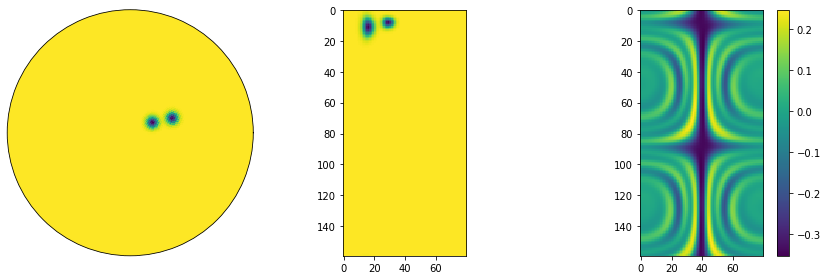

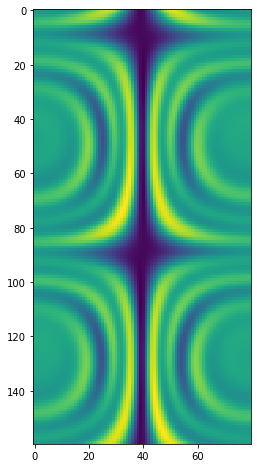

In [28]:
k = 4
n_col = 3
n_row = 1
plt.figure(figsize=(12, 4))
plt.subplot(n_row, n_col, 1, polar='True')
plt.gca().pcolormesh(th, rr, np.transpose(OutputArray[k, :, :], (1,0)))
plt.thetagrids([])
plt.rgrids([])

plt.subplot(n_row, n_col, 2)
plt.imshow(OutputArray[k, :, :])
plt.subplot(n_row, n_col, 3)
plt.imshow(InputArray[k, :, :])
plt.colorbar()
plt.tight_layout()

plt.figure(figsize=(12,8))
plt.imshow(InputArray[k, :, :])

In [29]:
output('alpha                   = %d\t' % alpha)
outputnewline()
output('Input data filename     = %s' % filenameIpt)
output("(Ns, Nd)                = (%d, %d)" % (Ns, Nd))
output("(Nt, Nr)                = (%d, %d)" % (Nt, Nr))
output("Nsamples                = %d" % Nsamples)
outputnewline()

alpha                   = 40	
Input data filename     = data//scafullYHN2.h5
(Ns, Nd)                = (160, 80)
(Nt, Nr)                = (160, 80)
Nsamples                = 20480


In [30]:
n_train = int(Nsamples * percent)
n_test  = min(max(n_train, 5000), Nsamples - n_train)
BATCH_SIZE = batch_size
n_valid = 512

In [31]:
factor = 1
InputArray *= factor
output(f'factor on the input data is {factor}')
mean_out = 0
max_out = np.amax(OutputArray)
min_out = np.amin(OutputArray)
pixel_max = max_out - min_out
OutputArray /= 0.5 * pixel_max
output(f'max / min of the output data are ({max_out:0.2f}, {min_out:0.2f})')
max_out = np.amax(OutputArray)
min_out = np.amin(OutputArray)
pixel_max = max_out - min_out
output(f'max / min of the output data are ({max_out:0.2f}, {min_out:0.2f})')

factor on the input data is 1
max / min of the output data are (-0.00, -1526.33)
max / min of the output data are (-0.00, -2.00)


In [32]:
n_input  = (Ns, Nd)
n_output = (Nt, Nr)
output("[n_input, n_output] = [(%d,%d),  (%d,%d)]" % (n_input + n_output))
output("[n_train, n_test, n_valid]   = [%d, %d, %d]" % (n_train, n_test, n_valid))
output("batch size = %d" % BATCH_SIZE)
output("noise rate = %.2e" % noise_rate)

[n_input, n_output] = [(160,80),  (160,80)]
[n_train, n_test, n_valid]   = [16384, 4096, 512]
batch size = 32
noise rate = 0.00e+00


In [33]:
X_train = InputArray[0:n_train, :, :]
Y_train = OutputArray[0:n_train, :, :]
X_test  = InputArray[n_train:(n_train+n_test), :, :]
Y_test  = OutputArray[n_train:(n_train+n_test), :, :]

# ---------- add noise on the input data ----------------------
noiseTrain = np.random.randn(n_train, Ns, Nd) * noise_rate
X_train = X_train * (1 + noiseTrain)
noiseTest = np.random.randn(n_test, Ns, Nd) * noise_rate
X_test = X_test * (1 + noiseTest)

In [13]:
weight_pixel = np.arange(1, 2*Nr+1, 2)

def PSNR(img1, img2, pixel_max=1.0):
    dimg = (img1 - img2) / pixel_max
    mse = np.maximum(np.mean(dimg**2), 1.e-10)
    return -10 * math.log10(mse)

def PSNRs(imgs1, imgs2, pixel_max=1.0):
    dimgs = (imgs1 - imgs2) / pixel_max
    mse = np.maximum(np.mean(dimgs**2, axis=(1,2)), 1.e-10)
    return -10 * np.mean(np.log10(mse))

def test_data(model, X, Y):
    Yhat = model.predict(X, n_valid)
    errs = np.linalg.norm((Yhat - Y) * weight_pixel, axis=(1, 2)) / np.linalg.norm((Y+mean_out) * weight_pixel, axis=(1, 2))
    return errs
#     return -PSNRs(Yhat, Y, pixel_max)

def check_result(model):
    return (test_data(model, X_train[0:n_valid, ...], Y_train[0:n_valid, ...]),
            test_data(model, X_test[0:n_valid, ...], Y_test[0:n_valid, ...]))

def test_data_mh(model_mh, X, Y):
    Yhat = model_mh.predict(X, n_valid)
    errs1 = np.linalg.norm((Yhat[0] - Y) * weight_pixel, axis=(1, 2)) / np.linalg.norm((Y+mean_out)*weight_pixel, axis=(1, 2))
    errs2 = np.linalg.norm((Yhat[1] - Y) * weight_pixel, axis=(1, 2)) / np.linalg.norm((Y+mean_out)*weight_pixel, axis=(1, 2))
    return (errs1, errs2)
#     return (-PSNRs(Yhat[0], Y, pixel_max), -PSNRs(Yhat[1], Y, pixel_max))

def check_result_mh(model_mh):
    return test_data_mh(model_mh, X_test[0:n_valid, ...], Y_test[0:n_valid, ...])

def splitScaling1D(X, alpha):
    return Lambda(lambda x: x[:, :, alpha:2*alpha])(X)


def splitWavelet1D(X, alpha):
    return Lambda(lambda x: x[:, :, 0:alpha])(X)

def Padding_x(x, s):
    return K.concatenate([x[:, x.shape[1]-s:x.shape[1], ...], x, x[:, 0:s, ...]], axis=1)

def __TriangleAdd(X, Y, alpha):
    return K.concatenate([X[:, :, 0:alpha], X[:, :, alpha:2*alpha] + Y], axis=2)

def TriangleAdd(X, Y, alpha):
    return Lambda(lambda x: __TriangleAdd(x[0], x[1], alpha))([X, Y])

In [14]:
bc = 'period'
w_comp = args.w_comp
w_interp = w_comp
L = math.floor(math.log2(Ns)) - 2  # number of levels
m = Ns // 2**L     # size of the coarse grid
m = 2 * ((m+1)//2) - 1
w = 2 * 3    # support of the wavelet function
n_b = 5      # bandsize of the matrix
output("(L, m) = (%d, %d)" % (L, m))

Ipt = Input(shape=n_input)
Ipt_c = CNNK1D(alpha, w_comp, activation='linear', bc_padding=bc)(Ipt)

bt_list = (L+1) * [None]
b = Ipt_c
for ll in range(1, L+1):
    bt = WaveLetC1D(2*alpha, w, activation='linear', use_bias=False)(b)
    bt_list[ll] = bt
    b = splitScaling1D(bt, alpha)

# (b,t) --> d
# d^L = A^L * b^L
d = b
for k in range(0, N_cnn):
    d = CNNK1D(alpha, m, activation='relu', bc_padding='period')(d)

# d = T^* * (D tb + (0,d))
for ll in range(L, 0, -1):
    d1 = bt_list[ll]
    for k in range(0, N_cnn):
        d1 = CNNK1D(2*alpha, n_b, activation='relu', bc_padding='period')(d1)

#     d11 = splitWavelet1D(d1, alpha)
#     d12 = splitScaling1D(d1, alpha)
#     d12 = Add()([d12, d])
#     d = Concatenate(axis=-1)([d11, d12])
#     d = Lambda(lambda x: TriangleAdd(x[0], x[1], alpha))([d1, d])
    d = TriangleAdd(d1, d, alpha)
    d = InvWaveLetC1D(2*alpha, w//2, Nout=Nt//(2**(ll-1)), activation='linear', use_bias=False)(d)

Img_c = d

Img = CNNK1D(Nr, w_interp, activation='linear', bc_padding=bc)(Img_c)
Img_p = Reshape(n_output+(1,))(Img)
for k in range(0, N_cnn3-1):
    Img_p = Lambda(lambda x: Padding_x(x, 1))(Img_p)
    Img_p = ZeroPadding2D((0, 1))(Img_p)
    Img_p = Conv2D(4, 3, activation='relu')(Img_p)
    # Img_p = CNNK2D(4, 3, activation='relu', bc_padding=bc)(Img_p)

Img_p = Lambda(lambda x: Padding_x(x, 1))(Img_p)
Img_p = ZeroPadding2D((0, 1))(Img_p)
Img_p = Conv2D(1, 3, activation='linear')(Img_p)
# Img_p = CNNK2D(1, 3, activation='linear', bc_padding=bc)(Img_p)
Opt = Reshape(n_output)(Img_p)
Opt = Add()([Img, Opt])

(L, m) = (5, 5)





In [53]:
# plot_model(model, to_file='figeit2dInv.png', show_shapes=True)

In [15]:
lr_bs = []
for bs in range(0, 5):
    lr_bs.append([BATCH_SIZE * 2**bs, lr])

for ll in range(1, 5):
    lr_bs.append([BATCH_SIZE * 2**bs, lr * math.sqrt(0.1)**ll])
    
print(lr_bs)

[[32, 0.001], [64, 0.001], [128, 0.001], [256, 0.001], [512, 0.001], [512, 0.00031622776601683794], [512, 0.0001], [512, 3.16227766016838e-05], [512, 1e-05]]


In [16]:
lr_bs2 = []
for bs in range(3, 5):
    lr_bs2.append([BATCH_SIZE * 2**bs, lr])

for ll in range(1, 5):
    lr_bs2.append([BATCH_SIZE * 2**bs, lr * math.sqrt(0.1)**ll])
    
print(lr_bs2)

[[256, 0.001], [512, 0.001], [512, 0.00031622776601683794], [512, 0.0001], [512, 3.16227766016838e-05], [512, 1e-05]]


In [35]:
model_multihead = Model(inputs=Ipt, outputs=[Opt, Img])
model_multihead.compile(loss='mean_squared_error', optimizer='Nadam', loss_weights=[1., 1.])
model_multihead.optimizer.schedule_decay = (0.004)
output('number of params = %d' % model_multihead.count_params())
save_best_model_mh = SaveBestModel(modelfilename, check_result=check_result_mh, period=1,
                                   patience=10, output=output, test_weight=0., verbose=2)

number of params = 1209681


error: (0.03747, 0.04718), best error: (0.03747, 0.04718) at epoch 0, fit time = 8.5 secs
Epoch 1/80
 - 22s - loss: 8.9487e-05 - add_1_loss: 4.1856e-05 - cnn_k1d_38_loss: 4.7631e-05
error: (0.04597, 0.05402), best error: (0.03747, 0.04718) at epoch 0, fit time = 31.1 secs
Epoch 2/80
 - 19s - loss: 0.0111 - add_1_loss: 0.0042 - cnn_k1d_38_loss: 0.0069
error: (0.1604, 0.2625), best error: (0.03747, 0.04718) at epoch 0, fit time = 50.4 secs
Epoch 3/80
 - 19s - loss: 1.9210e-04 - add_1_loss: 6.9848e-05 - cnn_k1d_38_loss: 1.2226e-04
error: (0.09962, 0.1473), best error: (0.03747, 0.04718) at epoch 0, fit time = 69.7 secs
Epoch 4/80
 - 19s - loss: 1.0298e-04 - add_1_loss: 4.2890e-05 - cnn_k1d_38_loss: 6.0088e-05
error: (0.08535, 0.1099), best error: (0.03747, 0.04718) at epoch 0, fit time = 89.1 secs
Epoch 5/80
 - 19s - loss: 6.4151e-05 - add_1_loss: 2.7388e-05 - cnn_k1d_38_loss: 3.6762e-05
error: (0.07008, 0.09009), best error: (0.03747, 0.04718) at epoch 0, fit time = 108.4 secs
Epoch 6/80

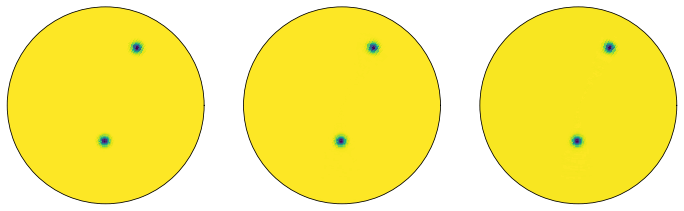

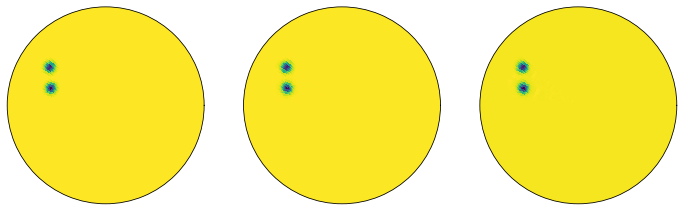

error: (0.03747, 0.04718), best error: (0.03747, 0.04718) at epoch 0, fit time = 206.1 secs
Epoch 81/120
 - 11s - loss: 2.2051e-05 - add_1_loss: 9.6416e-06 - cnn_k1d_38_loss: 1.2409e-05
error: (0.02976, 0.03887), best error: (0.02976, 0.03887) at epoch 81, fit time = 217.3 secs
Epoch 82/120
 - 11s - loss: 1.1599e-05 - add_1_loss: 4.7834e-06 - cnn_k1d_38_loss: 6.8157e-06
error: (0.02846, 0.03776), best error: (0.02846, 0.03776) at epoch 82, fit time = 228.5 secs
Epoch 83/120
 - 11s - loss: 9.1969e-06 - add_1_loss: 3.6756e-06 - cnn_k1d_38_loss: 5.5213e-06
error: (0.02746, 0.03699), best error: (0.02746, 0.03699) at epoch 83, fit time = 239.6 secs
Epoch 84/120
 - 11s - loss: 8.6534e-06 - add_1_loss: 3.4612e-06 - cnn_k1d_38_loss: 5.1922e-06
error: (0.0267, 0.03587), best error: (0.0267, 0.03587) at epoch 84, fit time = 250.7 secs
Epoch 85/120
 - 11s - loss: 8.2531e-06 - add_1_loss: 3.3496e-06 - cnn_k1d_38_loss: 4.9035e-06
error: (0.02762, 0.0354), best error: (0.0267, 0.03587) at epoch 84,

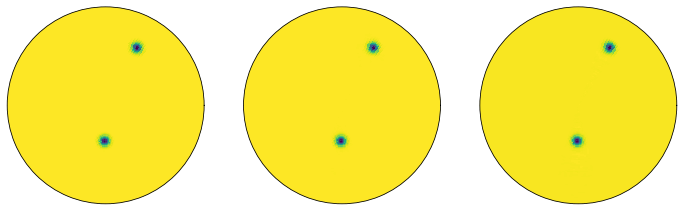

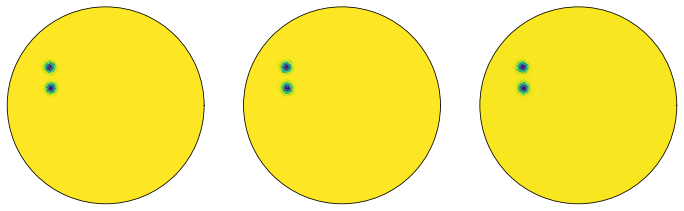

error: (0.02469, 0.0328), best error: (0.02469, 0.0328) at epoch 95, fit time = 484.0 secs
Epoch 121/160
 - 7s - loss: 3.8813e-06 - add_1_loss: 1.3914e-06 - cnn_k1d_38_loss: 2.4899e-06
error: (0.02249, 0.03078), best error: (0.02249, 0.03078) at epoch 121, fit time = 491.7 secs
Epoch 122/160
 - 7s - loss: 3.6358e-06 - add_1_loss: 1.2654e-06 - cnn_k1d_38_loss: 2.3704e-06
error: (0.02228, 0.03045), best error: (0.02228, 0.03045) at epoch 122, fit time = 499.4 secs
Epoch 123/160
 - 7s - loss: 3.6031e-06 - add_1_loss: 1.2703e-06 - cnn_k1d_38_loss: 2.3329e-06
error: (0.02212, 0.03022), best error: (0.02212, 0.03022) at epoch 123, fit time = 507.1 secs
Epoch 124/160
 - 7s - loss: 3.4450e-06 - add_1_loss: 1.1966e-06 - cnn_k1d_38_loss: 2.2484e-06
error: (0.02205, 0.03005), best error: (0.02205, 0.03005) at epoch 124, fit time = 514.9 secs
Epoch 125/160
 - 7s - loss: 3.3672e-06 - add_1_loss: 1.1738e-06 - cnn_k1d_38_loss: 2.1933e-06
error: (0.02208, 0.02993), best error: (0.02205, 0.03005) at ep

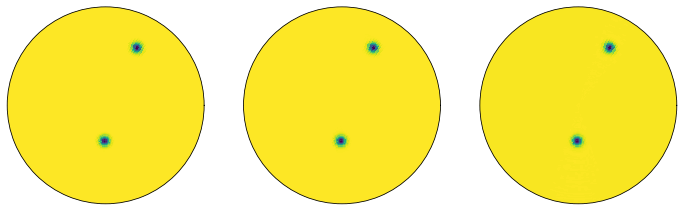

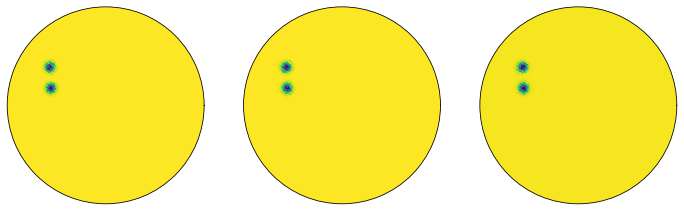

error: (0.02111, 0.02747), best error: (0.02111, 0.02747) at epoch 138, fit time = 699.0 secs
Epoch 161/200
 - 6s - loss: 2.8811e-06 - add_1_loss: 1.0500e-06 - cnn_k1d_38_loss: 1.8311e-06
error: (0.02096, 0.02729), best error: (0.02096, 0.02729) at epoch 161, fit time = 704.9 secs
Epoch 162/200
 - 6s - loss: 2.6455e-06 - add_1_loss: 9.4279e-07 - cnn_k1d_38_loss: 1.7027e-06
error: (0.0208, 0.02711), best error: (0.0208, 0.02711) at epoch 162, fit time = 710.8 secs
Epoch 163/200
 - 5s - loss: 2.6116e-06 - add_1_loss: 9.3043e-07 - cnn_k1d_38_loss: 1.6812e-06
error: (0.02073, 0.02699), best error: (0.02073, 0.02699) at epoch 163, fit time = 716.6 secs
Epoch 164/200
 - 6s - loss: 2.5753e-06 - add_1_loss: 9.1644e-07 - cnn_k1d_38_loss: 1.6589e-06
error: (0.02071, 0.02689), best error: (0.02073, 0.02699) at epoch 163, fit time = 722.4 secs
Epoch 165/200
 - 6s - loss: 2.5498e-06 - add_1_loss: 9.0890e-07 - cnn_k1d_38_loss: 1.6409e-06
error: (0.02067, 0.02685), best error: (0.02067, 0.02685) at e

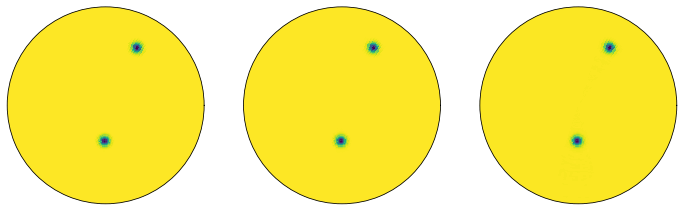

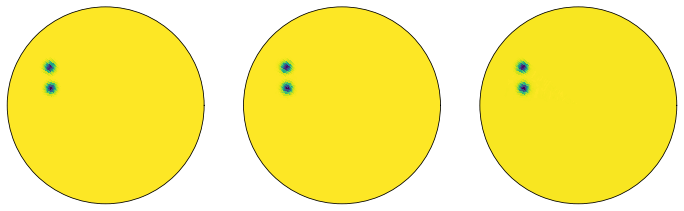

error: (0.02003, 0.02519), best error: (0.02003, 0.02519) at epoch 181, fit time = 880.0 secs
Epoch 201/240
 - 5s - loss: 3.3489e-06 - add_1_loss: 1.7460e-06 - cnn_k1d_38_loss: 1.6028e-06
error: (0.02109, 0.02571), best error: (0.02003, 0.02519) at epoch 181, fit time = 885.0 secs
Epoch 202/240
 - 5s - loss: 2.3470e-06 - add_1_loss: 8.8941e-07 - cnn_k1d_38_loss: 1.4576e-06
error: (0.02101, 0.02565), best error: (0.02003, 0.02519) at epoch 181, fit time = 889.9 secs
Epoch 203/240
 - 5s - loss: 2.4711e-06 - add_1_loss: 9.5382e-07 - cnn_k1d_38_loss: 1.5173e-06
error: (0.02332, 0.02748), best error: (0.02003, 0.02519) at epoch 181, fit time = 895.0 secs
Epoch 204/240
 - 5s - loss: 3.1577e-06 - add_1_loss: 1.3017e-06 - cnn_k1d_38_loss: 1.8560e-06
error: (0.02205, 0.02653), best error: (0.02003, 0.02519) at epoch 181, fit time = 899.9 secs
Epoch 205/240
 - 5s - loss: 2.3267e-06 - add_1_loss: 8.8592e-07 - cnn_k1d_38_loss: 1.4408e-06
error: (0.02026, 0.02504), best error: (0.02003, 0.02519) at

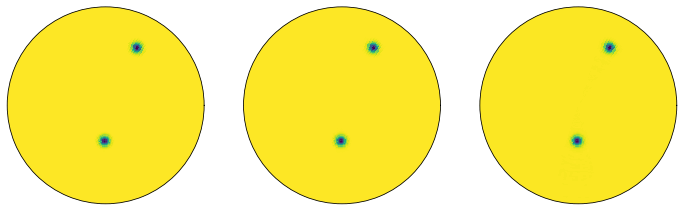

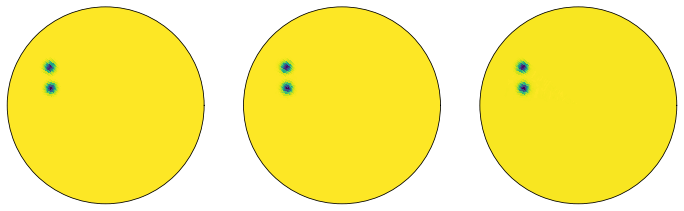

error: (0.02003, 0.02519), best error: (0.02003, 0.02519) at epoch 181, fit time = 930.0 secs
Epoch 241/280
 - 5s - loss: 5.1374e-06 - add_1_loss: 2.7507e-06 - cnn_k1d_38_loss: 2.3867e-06
error: (0.04112, 0.04197), best error: (0.02003, 0.02519) at epoch 181, fit time = 934.8 secs
Epoch 242/280
 - 5s - loss: 3.5922e-06 - add_1_loss: 1.5228e-06 - cnn_k1d_38_loss: 2.0693e-06
error: (0.02074, 0.02559), best error: (0.02003, 0.02519) at epoch 181, fit time = 939.7 secs
Epoch 243/280
 - 5s - loss: 2.2687e-06 - add_1_loss: 8.5364e-07 - cnn_k1d_38_loss: 1.4151e-06
error: (0.02024, 0.02505), best error: (0.02003, 0.02519) at epoch 181, fit time = 944.6 secs
Epoch 244/280
 - 5s - loss: 2.1848e-06 - add_1_loss: 8.1400e-07 - cnn_k1d_38_loss: 1.3708e-06
error: (0.02027, 0.02511), best error: (0.02003, 0.02519) at epoch 181, fit time = 949.5 secs
Epoch 245/280
 - 5s - loss: 2.3523e-06 - add_1_loss: 9.0141e-07 - cnn_k1d_38_loss: 1.4509e-06
error: (0.02444, 0.02851), best error: (0.02003, 0.02519) at

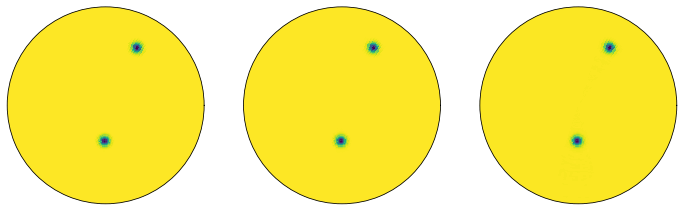

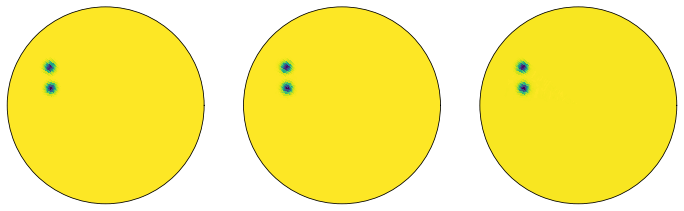

error: (0.02003, 0.02519), best error: (0.02003, 0.02519) at epoch 181, fit time = 979.4 secs
Epoch 281/320
 - 5s - loss: 7.1392e-06 - add_1_loss: 3.5761e-06 - cnn_k1d_38_loss: 3.5631e-06
error: (0.03046, 0.03446), best error: (0.02003, 0.02519) at epoch 181, fit time = 984.4 secs
Epoch 282/320
 - 5s - loss: 2.9810e-06 - add_1_loss: 1.2130e-06 - cnn_k1d_38_loss: 1.7680e-06
error: (0.02048, 0.0253), best error: (0.02003, 0.02519) at epoch 181, fit time = 989.3 secs
Epoch 283/320
 - 5s - loss: 2.2441e-06 - add_1_loss: 8.4169e-07 - cnn_k1d_38_loss: 1.4025e-06
error: (0.02114, 0.02571), best error: (0.02003, 0.02519) at epoch 181, fit time = 994.3 secs
Epoch 284/320
 - 5s - loss: 2.7981e-06 - add_1_loss: 1.1525e-06 - cnn_k1d_38_loss: 1.6456e-06
error: (0.03031, 0.03149), best error: (0.02003, 0.02519) at epoch 181, fit time = 999.2 secs
Epoch 285/320
 - 5s - loss: 3.9635e-06 - add_1_loss: 1.7884e-06 - cnn_k1d_38_loss: 2.1751e-06
error: (0.02521, 0.02906), best error: (0.02003, 0.02519) at 

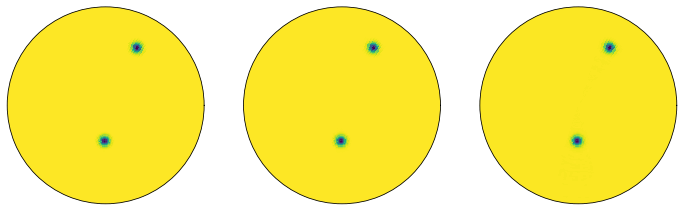

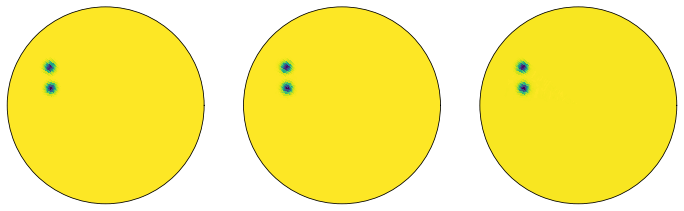

error: (0.02003, 0.02519), best error: (0.02003, 0.02519) at epoch 181, fit time = 1029.5 secs
Epoch 321/360
 - 5s - loss: 6.9773e-06 - add_1_loss: 3.7041e-06 - cnn_k1d_38_loss: 3.2732e-06
error: (0.02403, 0.02808), best error: (0.02003, 0.02519) at epoch 181, fit time = 1034.6 secs
Epoch 322/360
 - 5s - loss: 3.3757e-06 - add_1_loss: 1.4095e-06 - cnn_k1d_38_loss: 1.9662e-06
error: (0.03513, 0.03832), best error: (0.02003, 0.02519) at epoch 181, fit time = 1039.6 secs
Epoch 323/360
 - 5s - loss: 5.6240e-06 - add_1_loss: 2.5455e-06 - cnn_k1d_38_loss: 3.0785e-06
error: (0.02084, 0.02574), best error: (0.02003, 0.02519) at epoch 181, fit time = 1044.4 secs
Epoch 324/360
 - 5s - loss: 2.2467e-06 - add_1_loss: 8.4444e-07 - cnn_k1d_38_loss: 1.4023e-06
error: (0.0202, 0.02508), best error: (0.02003, 0.02519) at epoch 181, fit time = 1049.4 secs
Epoch 325/360
 - 5s - loss: 2.2695e-06 - add_1_loss: 8.6007e-07 - cnn_k1d_38_loss: 1.4094e-06
error: (0.02045, 0.02513), best error: (0.02003, 0.02519

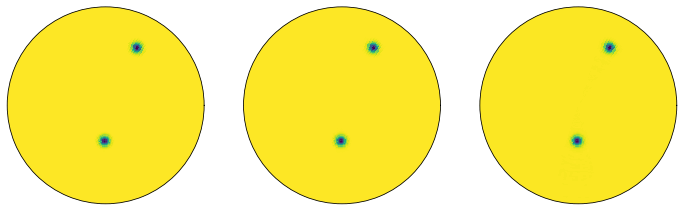

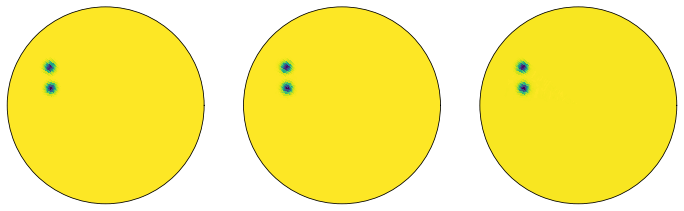

error: (0.02003, 0.02519), best error: (0.02003, 0.02519) at epoch 181, fit time = 1079.6 secs
Epoch 361/400
 - 5s - loss: 7.7614e-06 - add_1_loss: 3.7604e-06 - cnn_k1d_38_loss: 4.0009e-06
error: (0.04541, 0.03702), best error: (0.02003, 0.02519) at epoch 181, fit time = 1084.6 secs
Epoch 362/400
 - 5s - loss: 4.6061e-06 - add_1_loss: 2.2158e-06 - cnn_k1d_38_loss: 2.3903e-06
error: (0.02311, 0.0273), best error: (0.02003, 0.02519) at epoch 181, fit time = 1089.5 secs
Epoch 363/400
 - 5s - loss: 2.5753e-06 - add_1_loss: 1.0105e-06 - cnn_k1d_38_loss: 1.5648e-06
error: (0.02136, 0.02576), best error: (0.02003, 0.02519) at epoch 181, fit time = 1094.4 secs
Epoch 364/400
 - 5s - loss: 2.6589e-06 - add_1_loss: 1.0617e-06 - cnn_k1d_38_loss: 1.5972e-06
error: (0.02375, 0.02776), best error: (0.02003, 0.02519) at epoch 181, fit time = 1099.4 secs
Epoch 365/400
 - 5s - loss: 3.1935e-06 - add_1_loss: 1.3481e-06 - cnn_k1d_38_loss: 1.8454e-06
error: (0.02777, 0.0303), best error: (0.02003, 0.02519)

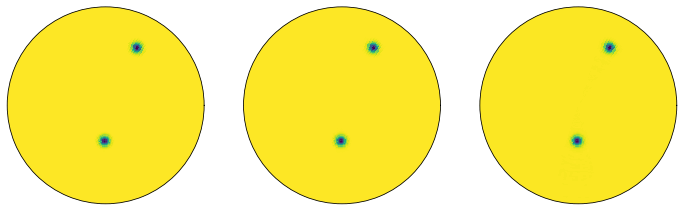

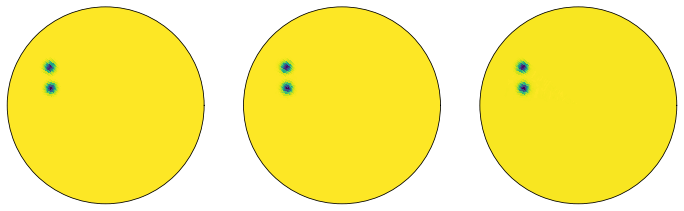

In [36]:
N_epoch = 40
n_epochs_pre = 0
N_e = n_epochs_pre + 2 * N_epoch
for b_s, l_r in lr_bs:
    model_multihead.optimizer.lr = (l_r)
    model_multihead.stop_training = False
    model_multihead.fit(X_train, [Y_train, Y_train], batch_size=b_s, epochs=N_e,
                        initial_epoch=n_epochs_pre, verbose=2, callbacks=[save_best_model_mh])
    n_epochs_pre = N_e
    N_e += N_epoch
    model_multihead.load_weights(modelfilename, by_name=False)  # re-load the best model
    save_best_model_mh.best_epoch_update = n_epochs_pre
    Yhat_tmp = model_multihead.predict(X_test[0:100, ...], 100)
    Yhat0 = Yhat_tmp[0]
    Yhat1 = Yhat_tmp[1]
#     print(f'PSNR for Opt: {PSNRs(Y_test[0:100, ...], Yhat0, pixel_max):.3g}')
#     print(f'PSNR for Img: {PSNRs(Y_test[0:100, ...], Yhat1, pixel_max):.3g}')
#     Yhat0 = np.maximum(np.minimum(Yhat0, max_out), min_out)
#     Yhat1 = np.maximum(np.minimum(Yhat1, max_out), min_out)
#     print(f'PSNR for Opt after post-precessing: {PSNRs(Y_test[0:100, ...], Yhat0, pixel_max):.3g}')
#     print(f'PSNR for Img after post-precessing: {PSNRs(Y_test[0:100, ...], Yhat1, pixel_max):.3g}')
    for idx in (0, 1):
        datas = [Y_test[idx, ...], Yhat0[idx, ...], Yhat1[idx, ...]]
        for k in range(len(datas)):
            datas[k] = np.transpose(datas[k], [1, 0])

        myPolarPlot(th, rr, datas)

In [37]:
if n_epochs_pre > 0:
    model_multihead.load_weights(modelfilename, by_name=False)  # re-load the best model

In [38]:
# model: final model
model = Model(inputs=Ipt, outputs=Opt)
model.compile(loss='mean_squared_error', optimizer='Nadam')
model.optimizer.schedule_decay = (0.004)
output('number of params = %d' % model.count_params())

number of params = 1209681


256 0.001
error: (0.01728, 0.02003), best error: (0.01728, 0.02003) at epoch 0, fit time = 8.4 secs
Epoch 401/480
 - 9s - loss: 1.9053e-05
error: (0.07251, 0.07332), best error: (0.01728, 0.02003) at epoch 0, fit time = 17.3 secs
Early stoped at epoch 400 with patience 10


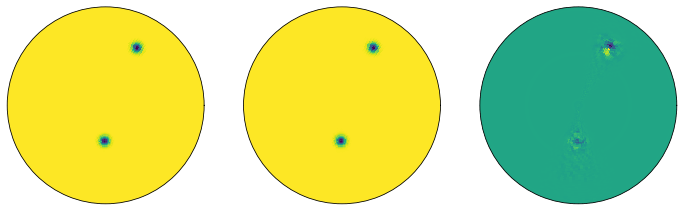

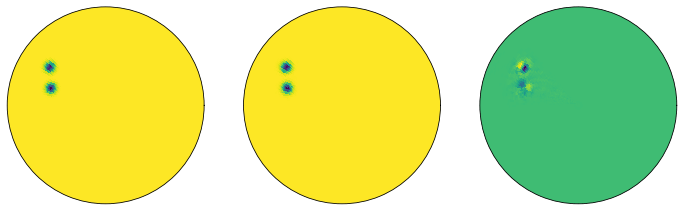

512 0.001
error: (0.01728, 0.02003), best error: (0.01728, 0.02003) at epoch 0, fit time = 18.2 secs
Epoch 481/520
 - 4s - loss: 2.8306e-05
error: (0.07989, 0.08156), best error: (0.01728, 0.02003) at epoch 0, fit time = 23.0 secs
Epoch 482/520
 - 4s - loss: 9.5623e-06
error: (0.04768, 0.04922), best error: (0.01728, 0.02003) at epoch 0, fit time = 27.7 secs
Epoch 483/520
 - 4s - loss: 1.5271e-05
error: (0.1074, 0.1079), best error: (0.01728, 0.02003) at epoch 0, fit time = 32.3 secs
Epoch 484/520
 - 4s - loss: 7.1722e-06
error: (0.02974, 0.03193), best error: (0.01728, 0.02003) at epoch 0, fit time = 36.8 secs
Epoch 485/520
 - 4s - loss: 1.1347e-05
error: (0.05283, 0.05393), best error: (0.01728, 0.02003) at epoch 0, fit time = 41.4 secs
Epoch 486/520
 - 4s - loss: 1.4726e-05
error: (0.03993, 0.04161), best error: (0.01728, 0.02003) at epoch 0, fit time = 46.0 secs
Epoch 487/520
 - 4s - loss: 3.8043e-06
error: (0.0394, 0.04106), best error: (0.01728, 0.02003) at epoch 0, fit time = 50

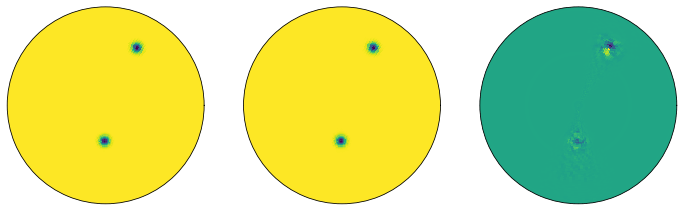

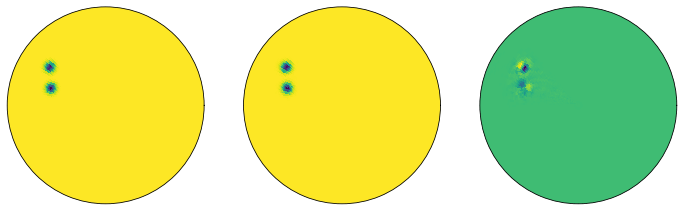

512 0.00031622776601683794
error: (0.01728, 0.02003), best error: (0.01728, 0.02003) at epoch 0, fit time = 65.6 secs
Epoch 521/560
 - 4s - loss: 0.0028
error: (0.5593, 0.5617), best error: (0.01728, 0.02003) at epoch 0, fit time = 70.3 secs
Epoch 522/560
 - 4s - loss: 7.6996e-04
error: (0.2093, 0.2093), best error: (0.01728, 0.02003) at epoch 0, fit time = 75.1 secs
Epoch 523/560
 - 5s - loss: 3.6106e-04
error: (0.1377, 0.1368), best error: (0.01728, 0.02003) at epoch 0, fit time = 79.9 secs
Epoch 524/560
 - 4s - loss: 1.1098e-04
error: (0.1093, 0.1074), best error: (0.01728, 0.02003) at epoch 0, fit time = 84.7 secs
Epoch 525/560
 - 5s - loss: 5.6893e-05
error: (0.09641, 0.09505), best error: (0.01728, 0.02003) at epoch 0, fit time = 89.6 secs
Epoch 526/560
 - 5s - loss: 4.2752e-05
error: (0.08778, 0.08652), best error: (0.01728, 0.02003) at epoch 0, fit time = 94.4 secs
Epoch 527/560
 - 4s - loss: 3.0106e-05
error: (0.08258, 0.08279), best error: (0.01728, 0.02003) at epoch 0, fit t

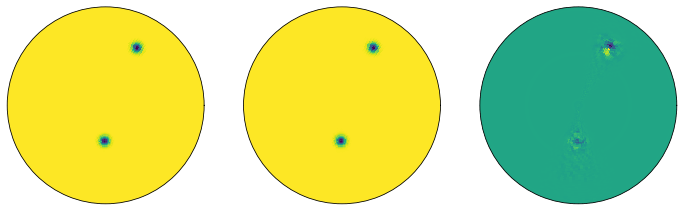

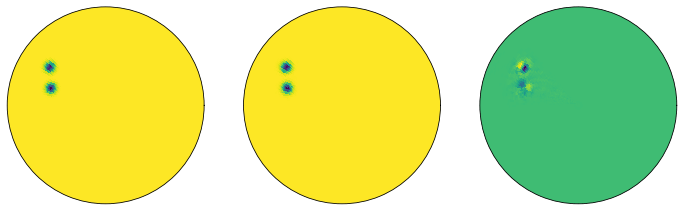

512 0.0001
error: (0.01728, 0.02003), best error: (0.01728, 0.02003) at epoch 0, fit time = 114.4 secs
Epoch 561/600
 - 5s - loss: 7.9477e-07
error: (0.01703, 0.01982), best error: (0.01703, 0.01982) at epoch 561, fit time = 119.3 secs
Epoch 562/600
 - 4s - loss: 7.7859e-07
error: (0.01697, 0.01976), best error: (0.01697, 0.01976) at epoch 562, fit time = 124.2 secs
Epoch 563/600
 - 4s - loss: 7.7272e-07
error: (0.01692, 0.01976), best error: (0.01697, 0.01976) at epoch 562, fit time = 128.9 secs
Epoch 564/600
 - 4s - loss: 7.6858e-07
error: (0.0169, 0.01973), best error: (0.0169, 0.01973) at epoch 564, fit time = 133.8 secs
Epoch 565/600
 - 4s - loss: 7.6569e-07
error: (0.01688, 0.0197), best error: (0.01688, 0.0197) at epoch 565, fit time = 138.5 secs
Epoch 566/600
 - 4s - loss: 7.6306e-07
error: (0.01685, 0.01968), best error: (0.01688, 0.0197) at epoch 565, fit time = 143.2 secs
Epoch 567/600
 - 4s - loss: 7.6057e-07
error: (0.01683, 0.01967), best error: (0.01683, 0.01967) at epoc

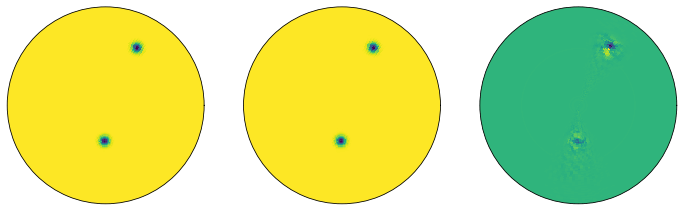

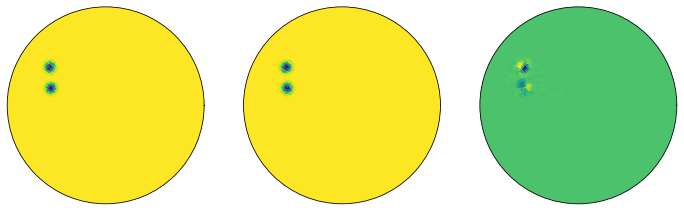

512 3.16227766016838e-05
error: (0.0165, 0.0194), best error: (0.0165, 0.0194) at epoch 590, fit time = 303.8 secs
Epoch 601/640
 - 4s - loss: 1.2989e-06
error: (0.05841, 0.06026), best error: (0.0165, 0.0194) at epoch 590, fit time = 308.6 secs
Epoch 602/640
 - 4s - loss: 2.4648e-06
error: (0.01798, 0.02097), best error: (0.0165, 0.0194) at epoch 590, fit time = 313.4 secs
Epoch 603/640
 - 4s - loss: 7.7496e-07
error: (0.01711, 0.02004), best error: (0.0165, 0.0194) at epoch 590, fit time = 318.1 secs
Epoch 604/640
 - 4s - loss: 7.9273e-07
error: (0.02045, 0.02294), best error: (0.0165, 0.0194) at epoch 590, fit time = 322.8 secs
Epoch 605/640
 - 4s - loss: 1.5376e-06
error: (0.04042, 0.04159), best error: (0.0165, 0.0194) at epoch 590, fit time = 327.4 secs
Epoch 606/640
 - 4s - loss: 1.5983e-06
error: (0.02123, 0.02382), best error: (0.0165, 0.0194) at epoch 590, fit time = 332.1 secs
Epoch 607/640
 - 4s - loss: 1.0170e-06
error: (0.02267, 0.02544), best error: (0.0165, 0.0194) at e

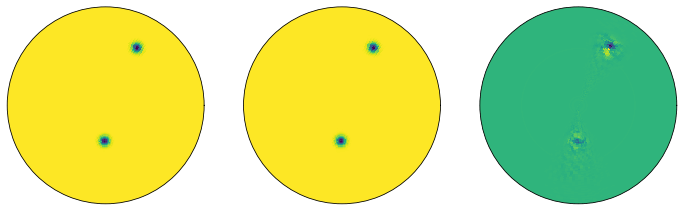

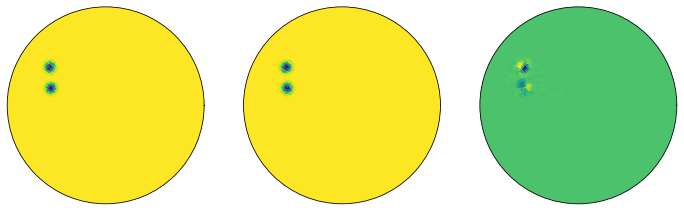

512 1e-05
error: (0.0165, 0.0194), best error: (0.0165, 0.0194) at epoch 590, fit time = 351.6 secs
Epoch 641/680
 - 4s - loss: 4.7479e-06
error: (0.0909, 0.09274), best error: (0.0165, 0.0194) at epoch 590, fit time = 356.3 secs
Epoch 642/680
 - 4s - loss: 3.6387e-06
error: (0.02568, 0.02815), best error: (0.0165, 0.0194) at epoch 590, fit time = 361.2 secs
Epoch 643/680
 - 4s - loss: 1.4386e-06
error: (0.02176, 0.02418), best error: (0.0165, 0.0194) at epoch 590, fit time = 365.8 secs
Epoch 644/680
 - 4s - loss: 1.0402e-06
error: (0.02271, 0.02511), best error: (0.0165, 0.0194) at epoch 590, fit time = 370.5 secs
Epoch 645/680
 - 4s - loss: 1.3033e-06
error: (0.02634, 0.02871), best error: (0.0165, 0.0194) at epoch 590, fit time = 375.2 secs
Epoch 646/680
 - 4s - loss: 1.3020e-06
error: (0.02484, 0.02729), best error: (0.0165, 0.0194) at epoch 590, fit time = 379.8 secs
Epoch 647/680
 - 4s - loss: 1.5157e-06
error: (0.02288, 0.02545), best error: (0.0165, 0.0194) at epoch 590, fit ti

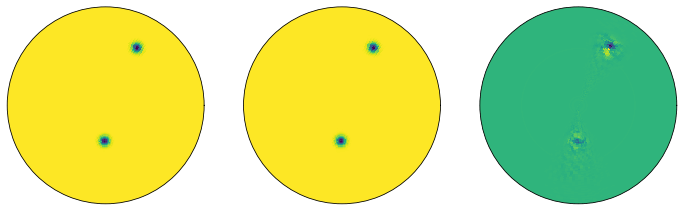

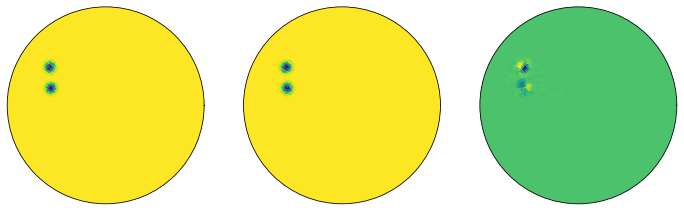

In [39]:
N_epoch = 40
save_best_model = SaveBestModel(modelfilename, check_result=check_result, period=1,
                                    patience=10, output=output, test_weight=1., verbose=2)
try:
    n_epochs_pre
except:
    n_epochs_pre = 0

N_e = n_epochs_pre + 2 * N_epoch
for b_s, l_r in lr_bs2:
    print(b_s, l_r)
    model.optimizer.lr = (l_r)
    model.stop_training = False
    model.fit(X_train, Y_train, batch_size=b_s, epochs=N_e,
              initial_epoch=n_epochs_pre, verbose=2, callbacks=[save_best_model])
    n_epochs_pre = N_e
    N_e += N_epoch
    model.load_weights(modelfilename, by_name=False)
    save_best_model.best_epoch_update = n_epochs_pre
    Yhat = model.predict(X_test[0:100, ...], 100)
#     print(f'PSNR for Opt: {PSNRs(Y_test[0:100, ...], Yhat, pixel_max):.3g}')
#     Yhat = np.maximum(np.minimum(Yhat, max_out), min_out)
#     print(f'PSNR for Opt after post-precessing: {PSNRs(Y_test[0:100, ...], Yhat, pixel_max):.3g}')
    dY = Yhat - Y_test[0:100, ...]
    for idx in (0, 1):
        datas = [Y_test[idx, ...], Yhat[idx, ...], dY[idx, ...]]
        for k in range(len(datas)):
            datas[k] = np.transpose(datas[k], [1, 0])

        myPolarPlot(th, rr, datas)

PSNR for Opt: 67.509
PSNR for Opt after post-precessing: 67.629


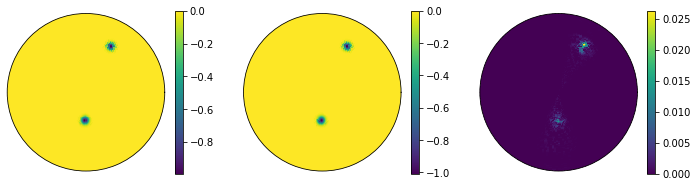

PSNR of sample k is:  68.63


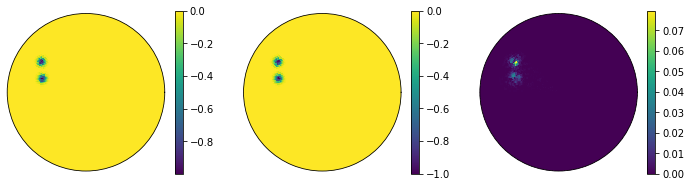

PSNR of sample k is:  59.93


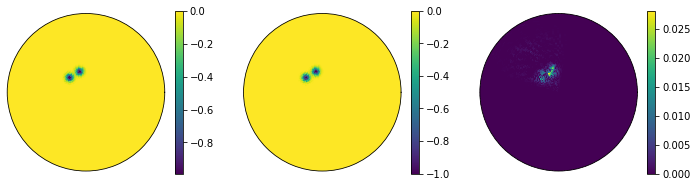

PSNR of sample k is:  63.52


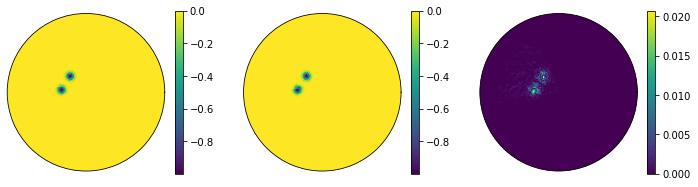

PSNR of sample k is:  66.86


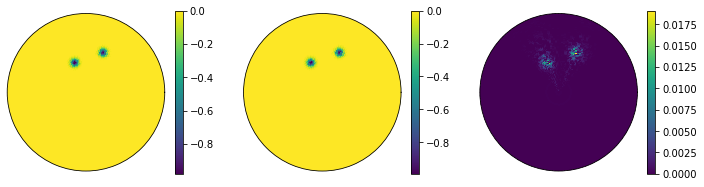

PSNR of sample k is:  69.41


In [40]:
Yhat = model.predict(X_test[0:100, ...], 100)
print(f'PSNR for Opt: {PSNRs(Y_test[0:100, ...], Yhat, pixel_max):.5g}')
Yhat = np.maximum(np.minimum(Yhat, max_out), min_out)
print(f'PSNR for Opt after post-precessing: {PSNRs(Y_test[0:100, ...], Yhat, pixel_max):.5g}')
dY = np.absolute(Yhat - Y_test[0:100, ...])
file_prefix = 'TTN4V1'
for idx in (0, 1, 2, 4, 8):
#     filename = 'figures/' + file_prefix + 'Sampling' + str(idx)
#     myPolarPlot(th, rr, [np.transpose(Y_test[idx, ...], [1, 0])], figsize=(6,6), n_col=1, filename=filename + 'Y.png')
#     myPolarPlot(th, rr, [np.transpose(Yhat[idx, ...], [1, 0])], figsize=(6,6), n_col=1, filename=filename + 'Ypred.png')
#     myPolarPlot(th, rr, [np.transpose(dY[idx, ...], [1, 0])], figsize=(6,6), n_col=1, filename=filename + 'dY.png')
    datas = [Y_test[idx, ...], Yhat[idx, ...], dY[idx, ...]]
    for k in range(len(datas)):
        datas[k] = np.transpose(datas[k], [1, 0])

    myPolarPlot(th, rr, datas, colorbar='on', figsize=(12, 3))
    print(f'PSNR of sample k is: {PSNR(Y_test[idx, ...], Yhat[idx, ...], pixel_max): .2f}')

In [ ]:
test_file = 'rteNus2Nua0SymG9'
n_test_new = 100
filenameTest = data_path + test_file + '.h5'
fin = h5py.File(filenameTest, 'r')
TestInput = fin['measurement_diff_' + data_type][0:n_test_new, :, :]
TestInput_bg = fin['measurement_' + data_type][:]
TestOutput = fin['us'][0:n_test_new, :, :]
TestOutput = np.transpose(TestOutput, [0, 2, 1])
TestInput *= Input_factor
TestInput_bg *= Input_factor
TestOutput -= 1

# ---------- add noise on the input data ----------------------
ns_rate = noise_rate
noiseTest = np.random.randn(n_test_new, Ns, Nd) * ns_rate
TestInput = TestInput * (1 + noiseTest) + TestInput_bg * noiseTest

TestYhat = model.predict(TestInput, min(n_test_new, 100))
TestYhat = np.maximum(np.minimum(TestYhat, 1), 0)
dY = TestYhat - TestOutput
for idx in range(0, 10):
    datas = [TestOutput[idx, ...], TestYhat[idx, ...], dY[idx, ...]]
    for k in range(len(datas)):
        datas[k] = np.transpose(datas[k], [1, 0])

    myPolarPlot(th, r, datas)